## TRANSFER LEARNING: IMPROVING ALGORITHM
---

### Libraries

In [1]:
#basic
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from os import listdir

#tensorflow and keras
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten, MaxPooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import Model

#sklearn
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split

#open cv
import cv2 as cv

#functions
from utils.images import load_images
from utils.train import series_to_array, get_classes_dictionary

### Constants

In [2]:
PATH = "/home/fernandofincatti/Documents/insper/pfe/ComputerAidedSkinCancerIdentificationAndDiagnosis/data/"
RANDOM_STATE = 42
TRAIN_SIZE = 0.7
VALIDATION_SIZE = 0.15
TEST_SIZE = 0.15
EPOCHS = 100
IMAGE_SHAPE = (128, 128, 3)

### Loading data

In [3]:
images, file_names = load_images(PATH+"images/", shape=IMAGE_SHAPE)
images_dataframe = pd.DataFrame({"image_array": images, "img_id": file_names})

In [4]:
metadata = pd.read_csv(PATH+"metadata.csv")

In [5]:
full_dataframe = metadata.merge(images_dataframe, how="left", on="img_id")

In [6]:
full_dataframe.head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed,image_array
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,...,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False,"[[[0.5882352941176471, 0.4117647058823529, 0.2..."
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True,"[[[0.6705882352941176, 0.5490196078431373, 0.5..."
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,...,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False,"[[[0.8509803921568627, 0.596078431372549, 0.58..."
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,...,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False,"[[[0.7803921568627451, 0.7490196078431373, 0.7..."
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,...,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True,"[[[0.5098039215686274, 0.39215686274509803, 0...."


### Test image

In [7]:
img_test = images_dataframe["image_array"][0]
file_test = images_dataframe["img_id"][0]

PAT_442_863_795.png


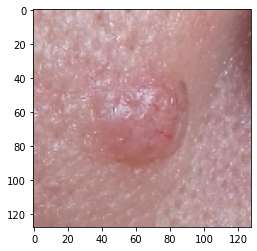

In [8]:
print(file_test)
plt.imshow(img_test)
plt.show()

### Split train, validation and test

In [9]:
features = full_dataframe["image_array"]
target = full_dataframe["diagnostic"]

In [10]:
x_train, y_train, x_valid, y_valid, x_test, y_test = train_valid_test_split(
    full_dataframe,
    target = "diagnostic",
    train_size=TRAIN_SIZE,
    valid_size=VALIDATION_SIZE,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE)

print("Train examples: {0}".format(x_train.shape[0]))
print("Validation examples: {0}".format(x_valid.shape[0]))
print("Test examples: {0}".format(x_test.shape[0]))

Train examples: 1608
Validation examples: 345
Test examples: 345


In [11]:
predictions_dictionary = get_classes_dictionary(y_train)

In [12]:
predictions_dictionary

{'SCC': 0, 'ACK': 1, 'BCC': 2, 'NEV': 3, 'SEK': 4, 'MEL': 5}

In [13]:
x_train_to_array = np.asarray(x_train["image_array"].tolist()).astype(np.float32)
x_test_to_array = np.asarray(x_test["image_array"].tolist()).astype(np.float32)
x_valid_to_array = np.asarray(x_valid["image_array"].tolist()).astype(np.float32)

In [14]:
y_train_to_array = series_to_array(y_train, predictions_dictionary) 
y_test_to_array = series_to_array(y_test, predictions_dictionary) 
y_valid_to_array = series_to_array(y_valid, predictions_dictionary) 

### Data augmentation

In [15]:
train_data_augmentation_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

### Model

In [16]:
#initialize the pretrained model
feature_extractor = keras.applications.ResNet50(
    weights='imagenet', 
    input_shape=IMAGE_SHAPE,
    include_top=False #whether to include the fully-connected layer at the top of the network.
)

2022-09-05 11:27:12.121613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 11:27:12.133629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 11:27:12.133767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 11:27:12.134167: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [17]:
feature_extractor.trainable = False #to make sure it's not being trained
input_layer = Input(shape=IMAGE_SHAPE)
pre_treined_model = feature_extractor(input_layer, training=False) #add input layer
pre_treined_model_with_polling = GlobalAveragePooling2D()(pre_treined_model) #add pooling layer
output_layer = Dense(6, activation='softmax')(pre_treined_model_with_polling)
model = Model(input_layer, output_layer)

In [18]:
model.compile( optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train

In [19]:
best_model_checkpoint = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    patience=5,
    restore_best_weights=True
)

In [20]:
training_history = model.fit(
    x = train_data_augmentation_generator.flow(
        x_train_to_array,
        y_train_to_array),
    epochs = EPOCHS,
    validation_data = (x_valid_to_array, y_valid_to_array),
    callbacks=[best_model_checkpoint]
)

Epoch 1/100


2022-09-05 11:27:16.568114: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


51/51 [==============================] - 9s 108ms/step - loss: 1.5794 - accuracy: 0.2935 - val_loss: 1.5025 - val_accuracy: 0.3797
Epoch 2/100
51/51 [==============================] - 4s 78ms/step - loss: 1.4908 - accuracy: 0.3588 - val_loss: 1.5008 - val_accuracy: 0.3797
Epoch 3/100
51/51 [==============================] - 4s 79ms/step - loss: 1.4917 - accuracy: 0.3576 - val_loss: 1.5013 - val_accuracy: 0.3797
Epoch 4/100
51/51 [==============================] - 4s 79ms/step - loss: 1.4911 - accuracy: 0.3601 - val_loss: 1.5054 - val_accuracy: 0.3652
Epoch 5/100
51/51 [==============================] - 4s 79ms/step - loss: 1.4907 - accuracy: 0.3619 - val_loss: 1.4958 - val_accuracy: 0.3797
Epoch 6/100
51/51 [==============================] - 4s 80ms/step - loss: 1.4922 - accuracy: 0.3539 - val_loss: 1.5019 - val_accuracy: 0.3797
Epoch 6: early stopping


In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=training_history.history['accuracy'],mode='lines', name='Acc - Training'))
fig.add_trace(go.Scatter(y=training_history.history['loss'],mode='lines', name='Training loss'))


In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=training_history.history['val_accuracy'],mode='lines', name='Acc - Validation'))
fig.add_trace(go.Scatter(y=training_history.history['val_loss'],mode='lines', name='Validation loss'))

### Evaluating the model

In [23]:
loss, acc = model.evaluate(
    x=x_test_to_array,
    y=y_test_to_array
)
print("model loss: {0}".format(loss))
print("model accuracy: {0}".format(acc))

11/11 [==============================] - 0s 36ms/step - loss: 1.5408 - accuracy: 0.3594
model loss: 1.5407955646514893
model accuracy: 0.3594202995300293


In [24]:
predictions = model.predict(x_test_to_array)

11/11 [==============================] - 1s 35ms/step


In [25]:
predictions_dictionary

{'SCC': 0, 'ACK': 1, 'BCC': 2, 'NEV': 3, 'SEK': 4, 'MEL': 5}

In [26]:
classe_names= y_train.unique().tolist()
classe_names

['SCC', 'ACK', 'BCC', 'NEV', 'SEK', 'MEL']

In [27]:
predictions_categorical = list()
for list_ar in predictions:
    predictions_categorical.append(classe_names[np.argmax(list_ar)])

In [28]:
y_train.value_counts(True)

BCC    0.366915
ACK    0.324627
NEV    0.106343
SEK    0.103856
SCC    0.076493
MEL    0.021766
Name: diagnostic, dtype: float64

In [29]:
pd.Series(predictions_categorical).value_counts(True)

BCC    1.0
dtype: float64